In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gensim
from adjustText import adjust_text
import multiprocessing
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
cores = multiprocessing.cpu_count()

In [3]:
df_data = pd.read_csv('../Data/data_2/clean_review_160k.csv')

In [4]:
encoding_label = {
    'positive': 0,
    'neutral': 1,
    'negative': 2
}

In [5]:
df_data['label'] = df_data['label'].map(encoding_label)
df_data

,text,rating,label
0,near airport good shuttle service stay night w...,2.0,2
1,get low rank reason positive thing say hotel s...,1.0,2
2,budget hotel pretend resort really motel level...,2.0,2
3,dish extra buck stay elsewhere place look acce...,1.0,2
4,l budget good low cost brand hotel near downto...,2.0,2
...,...,...,...
141736,fantastic mid range hotel u find well stay hot...,5.0,0
141737,fantastic service staff encounter property mak...,4.0,0
141738,great find stay previously stay theatre distri...,4.0,0
141739,convenient location airport stay start road tr...,4.0,0


In [6]:
x_train, x_test, y_train, y_test = train_test_split(df_data['text'], df_data['label'], test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_val.shape, y_val.shape

((113392,), (14174,), (113392,), (14174,), (14175,), (14175,))

In [7]:
sentences = df_data['text'].str.split().tolist()

model_wv = gensim.models.Word2Vec(sentences, vector_size=200, window=9, min_count=1, workers=cores-1)

In [8]:
words = list(model_wv.wv.key_to_index)[:200]
embeddings = model_wv.wv[words]

pca = PCA(n_components=10, random_state=42).fit_transform(embeddings)
embeddings_2d = TSNE(n_components=2, random_state=42, perplexity=5).fit_transform(pca)

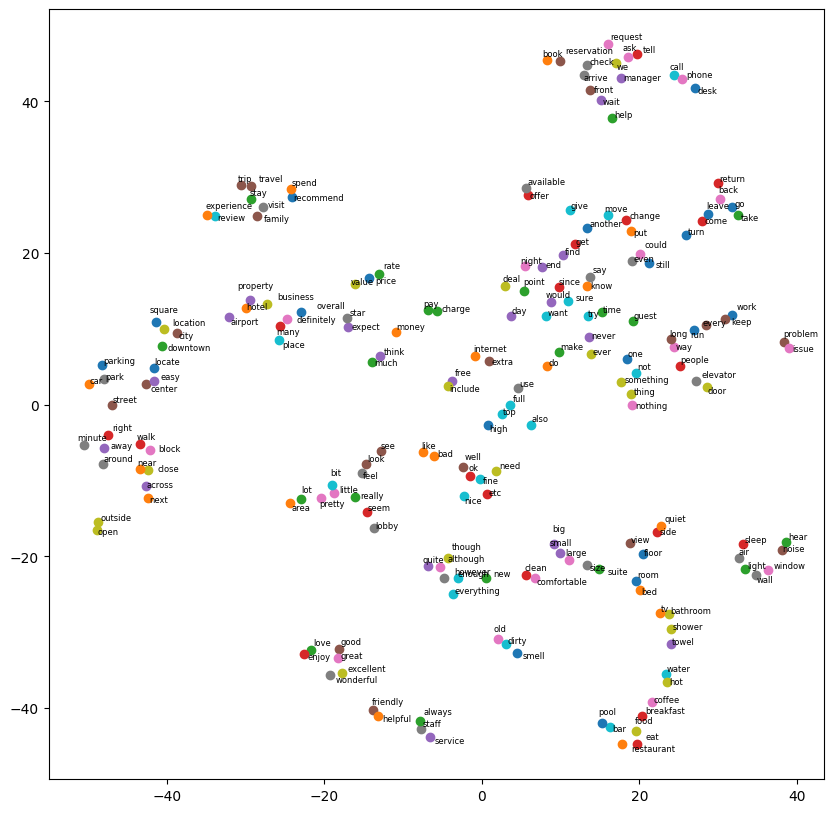

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, word in enumerate(words):
    x, y = embeddings_2d[i]
    ax.scatter(x, y)
    ax.text(x, y, word, fontsize=6)

adjust_text(ax.texts)
plt.show()

In [10]:
MAXLEN = 32
MAX_EXAMPLES = len(model_wv.wv.key_to_index)
EMBEDDING_DIM = model_wv.wv.vector_size
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = '<OOV>'
NUM_LABELS = 5

embedding_matrix = np.zeros((MAX_EXAMPLES, EMBEDDING_DIM))
for word, i in model_wv.wv.key_to_index.items():
    embedding_matrix[i] = model_wv.wv[word]

In [11]:
tokenizer = Tokenizer(num_words=MAX_EXAMPLES, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_val_pad = pad_sequences(x_val_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_EXAMPLES, EMBEDDING_DIM, input_length=MAXLEN,weights=[embedding_matrix], trainable=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_LABELS, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 200)           13127000  
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 64)                409664    
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 13,536,989
Trainable params: 13,536,989
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(x_train_pad, y_train, epochs=10, validation_data=(x_test_pad, y_test))

Epoch 1/10
3544/3544 [==============================] - 485s 137ms/step - loss: 0.7297 - accuracy: 0.6688 - val_loss: 0.6187 - val_accuracy: 0.7290
Epoch 2/10
3544/3544 [==============================] - 494s 139ms/step - loss: 0.5587 - accuracy: 0.7577 - val_loss: 0.6040 - val_accuracy: 0.7364
Epoch 3/10
3544/3544 [==============================] - 496s 140ms/step - loss: 0.4693 - accuracy: 0.8030 - val_loss: 0.6474 - val_accuracy: 0.7272
Epoch 4/10
3544/3544 [==============================] - 502s 142ms/step - loss: 0.3770 - accuracy: 0.8467 - val_loss: 0.7238 - val_accuracy: 0.7192
Epoch 5/10
3544/3544 [==============================] - 504s 142ms/step - loss: 0.2961 - accuracy: 0.8814 - val_loss: 0.8584 - val_accuracy: 0.7071
Epoch 6/10
3544/3544 [==============================] - 492s 139ms/step - loss: 0.2291 - accuracy: 0.9096 - val_loss: 1.0575 - val_accuracy: 0.6968
Epoch 7/10
3544/3544 [==============================] - 491s 139ms/step - loss: 0.1768 - accuracy: 0.9302 - val_

In [15]:
val_loss, val_accuracy = model.evaluate(x_val_pad, y_val)

443/443 [==============================] - 1s 2ms/step - loss: 2.0119 - accuracy: 0.6932


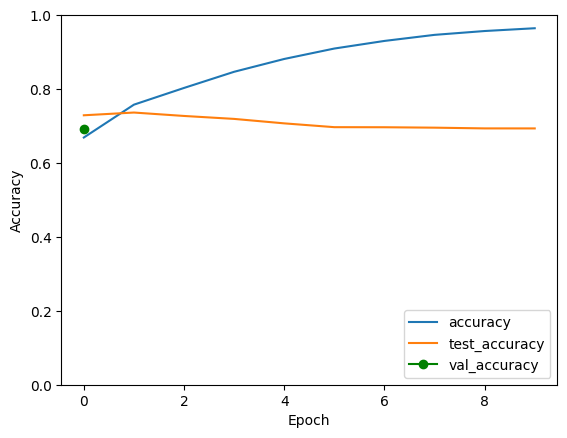

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.plot(val_accuracy, label='val_accuracy',marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [17]:
predictions = model.predict(x_val_pad)
predictions = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_val, predictions)

443/443 [==============================] - 1s 2ms/step


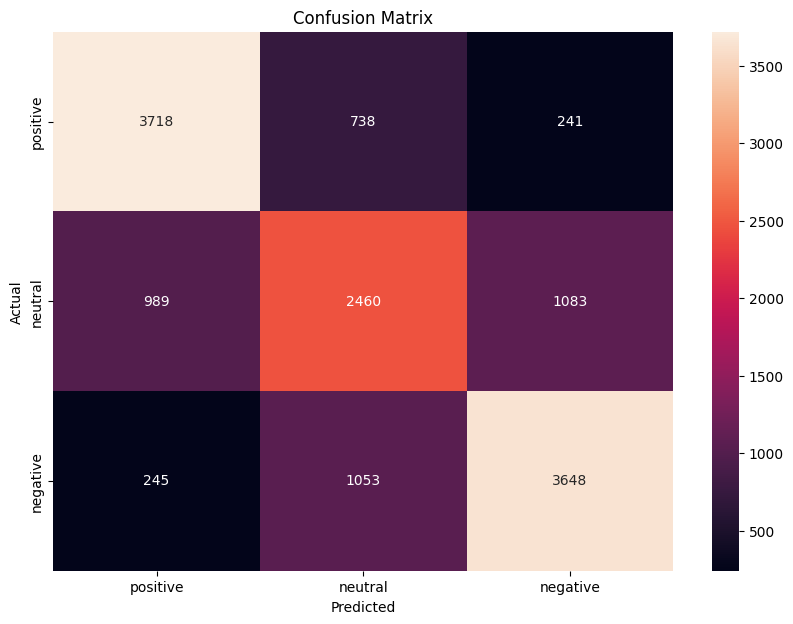

In [18]:
df_confusion_matrix = pd.DataFrame(conf_matrix, index = ['positive', 'neutral', 'negative'], columns = ['positive', 'neutral', 'negative'])
plt.figure(figsize=(10,7))
plt.title('Confusion Matrix')
sns.heatmap(df_confusion_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()